# Real-world Data Wrangling

In this project, you will apply the skills you acquired in the course to gather and wrangle real-world data with two datasets of your choice.

You will retrieve and extract the data, assess the data programmatically and visually, accross elements of data quality and structure, and implement a cleaning strategy for the data. You will then store the updated data into your selected database/data store, combine the data, and answer a research question with the datasets.

Throughout the process, you are expected to:

1. Explain your decisions towards methods used for gathering, assessing, cleaning, storing, and answering the research question
2. Write code comments so your code is more readable

## 1. Gather data

In this section, you will extract data using two different data gathering methods and combine the data. Use at least two different types of data-gathering methods.

### **1.1.** Problem Statement
In 2-4 sentences, explain the kind of problem you want to look at and the datasets you will be wrangling for this project.

*FILL IN:* I am looking to compare how the fluctuation of various stock indexes attributed to reported GDP on an annual basis for the years 2020 - 2023. I believe that using the Bureau of Economic Analysis for federal government reporting of annualized GDP by industrial sector will be the flagship of my data, with fill-ins from the nasdaq data will help tie this whole thing together by having an standardized model of what stock tickers belong to each industry and then comparing the percent change.

### **1.2.** Gather at least two datasets using two different data gathering methods

List of data gathering methods:

- Download data manually
- Programmatically downloading files
- Gather data by accessing APIs
- Gather and extract data from HTML files using BeautifulSoup
- Extract data from a SQL database

Each dataset must have at least two variables, and have greater than 500 data samples within each dataset.

For each dataset, briefly describe why you picked the dataset and the gathering method (2-3 full sentences), including the names and significance of the variables in the dataset. Show your work (e.g., if using an API to download the data, please include a snippet of your code). 

Load the dataset programmtically into this notebook.

#### **Dataset 1**

Type: CSV file

Method: API from Bureau of Economic Analysis https://apps.bea.gov/API/signup/

Dataset variables:

*   **Variable** **1** Industry (returned as an int value from BEA, will need to modify to compare with kaggle stock data)
*   **Variable** **2** DataValue - the amount of GDP generated by the industry across the timeframe specified.

In [3]:
%pip install seaborn

  Using cached seaborn-0.13.2-py3-none-any.whl.metadata (5.4 kB)
Using cached seaborn-0.13.2-py3-none-any.whl (294 kB)
Note: you may need to restart the kernel to use updated packages.


In [4]:
# getting all imports squared away
import requests as req
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import json


In [13]:
api_key = "E202F759-759F-424F-BEBA-158DCD981AAA"
base_url = "https://apps.bea.gov/api/data/"

# Parameters for the API request
params = {
    "UserID": api_key,          # Your API key
    "method": "GetData",        # API method
    "datasetname": "GDPbyIndustry",  # Dataset
    "Frequency": "A",           # Annual data (use "Q" for quarterly)
    "Year": "2020,2021,2022,2023",        # Data from 2010 to 2023
    "Industry": "ALL",          # Retrieve data for all industries
    "TableID": "6",             # TableID for value-added contributions (GDP by industry)
    "ResultFormat": "JSON"      # Request data in JSON format
}

# Send the API request
response = req.get(base_url, params=params)

# Check for a successful response
if response.status_code == 200:
    # Parse the JSON response
    data = response.json()
    # Extract the relevant data from the response
    results = data['BEAAPI']['Results']
    
    print(data['BEAAPI'])
    # Convert the data to a Pandas DataFrame
    df = pd.DataFrame(results)
    # Display the DataFrame
else:
    print(f"API request failed with status code: {response.status_code}")
    print(response.text)

# Extract the nested "Data" column from the DataFrame
nested_data = df.loc[0, "Data"]  # Extract the list of dictionaries in the "Data" column

# print("this is the nested data", nested_data.iter())

# Convert the nested data into a DataFrame
bea_df = pd.DataFrame(nested_data)

# Preview the flattened data
print(bea_df.head())

# Save to CSV for later processing, if needed
bea_df.to_csv("./data_files/bea_gdp_by_industry_raw.csv", index=False)

# Display the full DataFrame's structure to ensure all columns are present
print(bea_df.info())

{'Request': {'RequestParam': [{'ParameterName': 'USERID', 'ParameterValue': 'E202F759-759F-424F-BEBA-158DCD981AAA'}, {'ParameterName': 'METHOD', 'ParameterValue': 'GETDATA'}, {'ParameterName': 'DATASETNAME', 'ParameterValue': 'GDPBYINDUSTRY'}, {'ParameterName': 'FREQUENCY', 'ParameterValue': 'A'}, {'ParameterName': 'YEAR', 'ParameterValue': '2020,2021,2022,2023'}, {'ParameterName': 'INDUSTRY', 'ParameterValue': 'ALL'}, {'ParameterName': 'TABLEID', 'ParameterValue': '6'}, {'ParameterName': 'RESULTFORMAT', 'ParameterValue': 'JSON'}]}, 'Results': [{'Statistic': 'GDP by Industry Table', 'UTCProductionTime': '2025-09-16T20:11:05.710', 'Dimensions': [{'Ordinal': '1', 'Name': 'TableID', 'DataType': 'numeric', 'IsValue': '0'}, {'Ordinal': '2', 'Name': 'Frequency', 'DataType': 'string', 'IsValue': '0'}, {'Ordinal': '3', 'Name': 'Year', 'DataType': 'string', 'IsValue': '0'}, {'Ordinal': '4', 'Name': 'Quarter', 'DataType': 'string', 'IsValue': '0'}, {'Ordinal': '5', 'Name': 'Industry', 'DataType'

Optional data storing step: You may save your raw dataset files to the local data store before moving to the next step.

#### Dataset 2

Type: CSV file

Method: Manually downloaded from https://www.nasdaq.com/market-activity/stocks/screener using cURL

Dataset variables:

*   **Variable 1** Stock ticker, same as kaggle data
*   **Variable 2** Sector/Industry, same as BEA data. 

- This dataset is downloaded inorder to act as a middleman of sorts between the two other datasets. The BEA offers holistic views of entire industries, and the kaggle dataset offers view of individual stocks on a day-by-day change. This dataset will offer a way to perform joins and other data-wrangling steps on similar tables

In [12]:
# Define the URL and headers
url = "https://api.nasdaq.com/api/screener/stocks?tableonly=false&limit=25&download=true"
headers = {
    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36"
}

# Define the file name
file_name = "./data_files/nasdaq_data_raw.csv"

# Function to parse and format the nested data
def save_nasdaq_data(path_to_file):
    with open(path_to_file, 'r') as file:
        raw_content = file.read()
    # Parse the JSON structure
    try:
        nasdaq_data = json.loads(raw_content)
        # Extract the rows from nested data
        rows = nasdaq_data.get('data', {}).get('rows', [])
        
        if rows:
            # Create a DataFrame from the rows
            nasdaq_df = pd.DataFrame(rows)
            
            # Example of additional formatting:
            # Drop unnecessary columns (customize this based on the structure)
            columns_to_drop = [col for col in nasdaq_df.columns if 'unnecessary' in col.lower()]  # Example
            nasdaq_df = nasdaq_df.drop(columns=columns_to_drop, errors='ignore')

            # Reset the index
            nasdaq_df = nasdaq_df.reset_index(drop=True)

            # Ensure proper data types for better processing
            for col in nasdaq_df.select_dtypes(include='object').columns:
                nasdaq_df[col] = nasdaq_df[col].str.strip()

            return nasdaq_df
        else:
            print("No data found in the 'rows' property.")
            return None
    except Exception as e:
        print(f"Error parsing the file: {e}")
        return None

# Check if the file exists and load immediately if it does
if os.path.exists(file_name):
    print(f"{file_name} already exists. Loading from disk...")
    nasdaq_df = save_nasdaq_data(file_name)
    if nasdaq_df is not None:
        print("Data successfully loaded and formatted.")
        print(nasdaq_df.head())  # Display a preview of the DataFrame
    else:
        print("Data formatting failed.")
else:
    # Make the GET request if the file does not exist
    response = req.get(url, headers=headers)

    if response.status_code == 200:
        # Save the response content to a CSV file
        with open(file_name, "wb") as file:
            file.write(response.content)
        print(f"Data successfully downloaded and saved to {file_name}")

        # Load the newly downloaded CSV
        nasdaq_df = save_nasdaq_data(file_name)
        if nasdaq_df is not None:
            print("Data successfully loaded and formatted.")
            print(nasdaq_df.head())  # Display a preview of the DataFrame
        else:
            print("Data formatting failed.")
    else:
        print(f"Failed to fetch data. Status code: {response.status_code}")

Data successfully downloaded and saved to ./data_files/nasdaq_data_raw.csv
Data successfully loaded and formatted.
  symbol                                               name lastsale  \
0      A             Agilent Technologies Inc. Common Stock  $127.12   
1     AA                     Alcoa Corporation Common Stock  $33.475   
2   AACB  Artius II Acquisition Inc. Class A Ordinary Sh...   $10.13   
3  AACBR                  Artius II Acquisition Inc. Rights    $0.20   
4  AACBU                   Artius II Acquisition Inc. Units   $10.30   

  netchange pctchange   volume       marketCap        country ipoyear  \
0      1.49    1.186%  1206500  36038574280.00  United States    1999   
1    -0.125   -0.372%  3993137   8667170352.00  United States    2016   
2      0.00     0.00%      104            0.00  United States    2025   
3      0.00     0.00%      735            0.00  United States    2025   
4      0.00     0.00%        2            0.00  United States    2025   

             

## 2. Assess data

Assess the data according to data quality and tidiness metrics using the report below.

List **two** data quality issues and **two** tidiness issues. Assess each data issue visually **and** programmatically, then briefly describe the issue you find.  **Make sure you include justifications for the methods you use for the assessment.**

### Quality Issue 1:

In [14]:
#FILL IN - Inspecting the dataframe programmatically
# Check for missing values
print("NASDAQ missing values")
# Check for missing values in NASDAQ DataFrame
missing_values = nasdaq_df.isnull().sum()

# Check data types of columns
data_types = nasdaq_df.dtypes

# Display a summary of missing values and data types
missing_values, data_types

NASDAQ missing values


(symbol       0
 name         0
 lastsale     0
 netchange    0
 pctchange    0
 volume       0
 marketCap    0
 country      0
 ipoyear      0
 industry     0
 sector       0
 url          0
 dtype: int64,
 symbol       object
 name         object
 lastsale     object
 netchange    object
 pctchange    object
 volume       object
 marketCap    object
 country      object
 ipoyear      object
 industry     object
 sector       object
 url          object
 dtype: object)

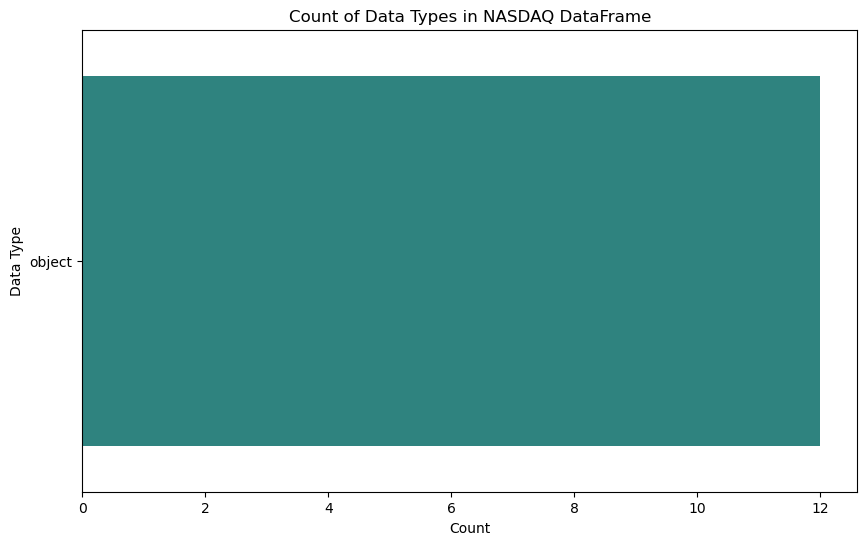

In [15]:
#FILL IN - Inspecting the dataframe visually
# Visualize outliers

# Visualize data types
plt.figure(figsize=(10, 6))
sns.countplot(y=nasdaq_df.dtypes, hue=nasdaq_df.dtypes, palette="viridis", legend=False)
plt.title("Count of Data Types in NASDAQ DataFrame")
plt.xlabel("Count")
plt.ylabel("Data Type")
plt.show()

### **Issue 1: Data Types**

#### Assessment:

- Programmatically: Use `.dtypes` to check data types of columns
- Visually: Plot a heatmap or summary table to show where missing data exists.

**Justification**: Several columns that should be numeric, such as `lastsale`, `netchange`, `pctchange`, `volume`, and `marketCap`, currently all are stored as **objects (strings)**.

### Quality Issue 2:

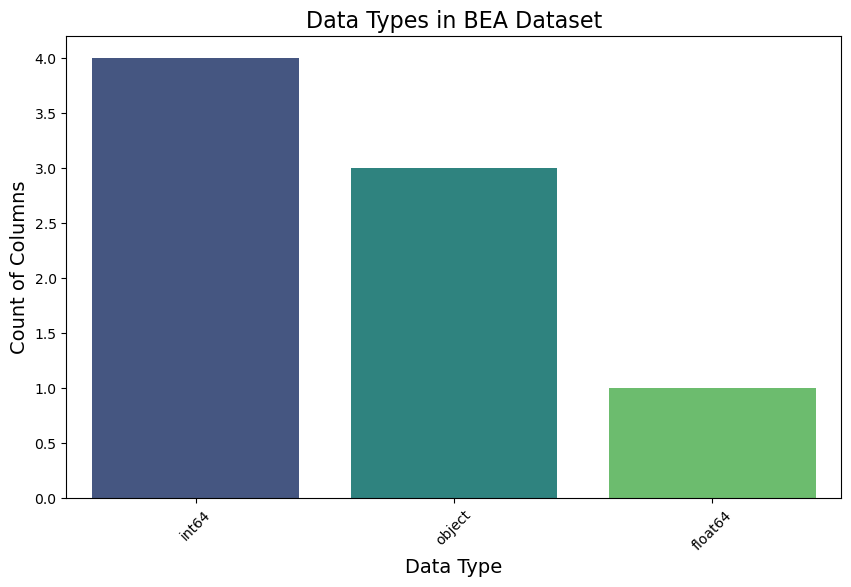

In [16]:
#FILL IN - Inspecting the dataframe visually
bea_df = pd.read_csv("./data_files/bea_gdp_by_industry_raw.csv")

# Count the occurrences of each data type
data_types_counts = bea_df.dtypes.value_counts()

# Create a bar chart to display the data types
plt.figure(figsize=(10, 6))
sns.barplot(x=data_types_counts.index.astype(str), y=data_types_counts.values, hue=data_types_counts.index.astype(str), palette="viridis", legend=False)

# Add labels and title
plt.title("Data Types in BEA Dataset", fontsize=16)
plt.xlabel("Data Type", fontsize=14)
plt.ylabel("Count of Columns", fontsize=14)
plt.xticks(rotation=45)
plt.show()

In [17]:
#FILL IN - Inspecting the dataframe programmatically
# Inspect data types of each column
print("BEA Data Types:")
print(bea_df.dtypes)

# Example: Check unique values in categorical columns for inconsistencies
print("\nUnique Values in 'Frequency':")
print(bea_df['Frequency'].unique())

print("\nUnique Values in 'IndustrYDescription':")
print(bea_df['IndustrYDescription'].unique())

BEA Data Types:
TableID                  int64
Frequency               object
Year                     int64
Quarter                  int64
Industry                object
IndustrYDescription     object
DataValue              float64
NoteRef                  int64
dtype: object

Unique Values in 'Frequency':
['A']

Unique Values in 'IndustrYDescription':
['Taxes on production and imports less subsidies'
 'Compensation of employees' 'Agriculture, forestry, fishing, and hunting'
 'Gross operating surplus' 'Farms'
 'Forestry, fishing, and related activities' 'Mining'
 'Oil and gas extraction' 'Mining, except oil and gas'
 'Support activities for mining' 'Utilities' 'Construction'
 'Food and beverage and tobacco products'
 'Textile mills and textile product mills'
 'Apparel and leather and allied products' 'Manufacturing'
 'Nondurable goods' 'Wood products' 'Paper products'
 'Printing and related support activities' 'Petroleum and coal products'
 'Chemical products' 'Plastics and rubber pro

### **Issue and justification**:
 -  #### **Value Consistency**:

    - **Potential Problem**: Categorical columns like Frequency or IndustrYDescription could have inconsistent capitalization or trailing spaces.
    - **Why it Matters**: These inconsistencies can lead to incorrect grouping or merging when aligning with other datasets.

### Tidiness Issue 1:

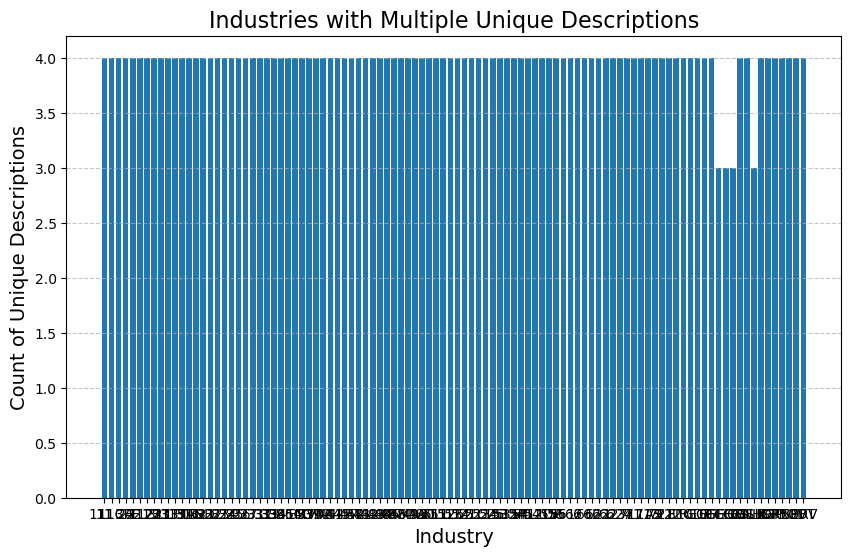

In [18]:
#FILL IN - Inspecting the dataframe visually

# Group by Industry and count unique IndustryDescription
description_counts = bea_df.groupby("Industry")["IndustrYDescription"].nunique()

# Filter industries with more than one unique description
extraneous_industries = description_counts[description_counts > 1]

# Plotting the extraneous rows
plt.figure(figsize=(10, 6))
plt.bar(extraneous_industries.index, extraneous_industries.values)
plt.title("Industries with Multiple Unique Descriptions", fontsize=16)
plt.xlabel("Industry", fontsize=14)
plt.ylabel("Count of Unique Descriptions", fontsize=14)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()

In [19]:
#FILL IN - Inspecting the dataframe programmatically
# Display the first few rows of the dataframe to understand its structure
bea_df.head(), bea_df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1584 entries, 0 to 1583
Data columns (total 8 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   TableID              1584 non-null   int64  
 1   Frequency            1584 non-null   object 
 2   Year                 1584 non-null   int64  
 3   Quarter              1584 non-null   int64  
 4   Industry             1584 non-null   object 
 5   IndustrYDescription  1584 non-null   object 
 6   DataValue            1584 non-null   float64
 7   NoteRef              1584 non-null   int64  
dtypes: float64(1), int64(4), object(3)
memory usage: 99.1+ KB


(   TableID Frequency  Year  Quarter Industry  \
 0        6         A  2020     2020       11   
 1        6         A  2020     2020       11   
 2        6         A  2020     2020       11   
 3        6         A  2020     2020       11   
 4        6         A  2020     2020    111CA   
 
                               IndustrYDescription  DataValue  NoteRef  
 0  Taxes on production and imports less subsidies      -34.9        6  
 1                       Compensation of employees       60.7        6  
 2     Agriculture, forestry, fishing, and hunting      162.9        6  
 3                         Gross operating surplus      137.1        6  
 4  Taxes on production and imports less subsidies      -34.7        6  ,
 None)

### **Issue and justification**:
- Each Industry in the BEA csv file has multiple rows split up and makes the data too granular. It needs to be collated down into just the industry and the datavalue as a summation of all things.

### Tidiness Issue 2: 

In [20]:
#FILL IN - Inspecting the dataframe visually
# Displaying the first few rows and summary of the DataFrame
if 'nasdaq_df' in locals() and nasdaq_df is not None:
    print("Visual Inspection of DataFrame:")
    print(nasdaq_df.head(10))  # Display first 10 rows
    print("\nColumn Data Types and Non-Null Counts:")
    print(nasdaq_df.info())  # Check data types and non-null counts
else:
    print("The DataFrame is not loaded.")


Visual Inspection of DataFrame:
  symbol                                               name lastsale  \
0      A             Agilent Technologies Inc. Common Stock  $127.12   
1     AA                     Alcoa Corporation Common Stock  $33.475   
2   AACB  Artius II Acquisition Inc. Class A Ordinary Sh...   $10.13   
3  AACBR                  Artius II Acquisition Inc. Rights    $0.20   
4  AACBU                   Artius II Acquisition Inc. Units   $10.30   
5   AACG   ATA Creativity Global American Depositary Shares   $2.495   
6   AACI  Armada Acquisition Corp. II Class A Ordinary S...   $10.27   
7  AACIW                Armada Acquisition Corp. II Warrant    $0.71   
8   AACT  Ares Acquisition Corporation II Class A Ordina...   $11.40   
9    AAL          American Airlines Group Inc. Common Stock   $12.42   

  netchange pctchange    volume       marketCap        country ipoyear  \
0      1.49    1.186%   1206500  36038574280.00  United States    1999   
1    -0.125   -0.372%   399

In [21]:
#FILL IN - Inspecting the dataframe programmatically
# File path
file_path = './data_files/nasdaq_data_raw.csv'

# Read the file in chunks to inspect the structure
chunk_size = 1000  # Number of rows per chunk
try:
    # Read the first chunk to preview the structure
    chunk = pd.read_csv(file_path, chunksize=chunk_size, delimiter=',', encoding='utf-8')
    first_chunk = next(chunk)  # Extract the first chunk
    
    # Display summary and first few rows of the chunk
    print("Columns in the first chunk:")
    print(first_chunk.columns)
    print("\nPreview of the first chunk:")
    print(first_chunk.head())
    # Display the shape of the chunk
    print(f"Chunk shape: {first_chunk.shape}")

except Exception as e:
    print(f"Error reading the file: {e}")


Columns in the first chunk:
Index(['{"data":{"asOf":null', 'headers:{"symbol":"Symbol"', 'name:"Name"',
       'lastsale:"Last Sale"', 'netchange:"Net Change"',
       'pctchange:"% Change"', 'marketCap:"Market Cap"', 'country:"Country"',
       'ipoyear:"IPO Year"', 'volume:"Volume"',
       ...
       'marketCap:"47415497.00"', 'country:"United States".5320',
       'ipoyear:"".3054',
       'industry:"Biotechnology: Electromedical & Electrotherapeutic Apparatus".34',
       'sector:"Health Care".1138', 'url:"/market-activity/stocks/zyxi"}]}',
       'message:null', 'status:{"rCode":200', 'bCodeMessage:null',
       'developerMessage:null}}'],
      dtype='object', length=84329)

Preview of the first chunk:
Empty DataFrame
Columns: [{"data":{"asOf":null, headers:{"symbol":"Symbol", name:"Name", lastsale:"Last Sale", netchange:"Net Change", pctchange:"% Change", marketCap:"Market Cap", country:"Country", ipoyear:"IPO Year", volume:"Volume", sector:"Sector", industry:"Industry", url:"U

### **Issue and justification**: 
#### **Bad CSV mapping**:
- **Malformed Column Names**: 
    - The column names are overly verbose and look like they are improperly parsed from a JSON structure.
- **Empty Rows**: 
    - The chunk preview indicates no actual rows were loaded (Index: []), implying a parsing failure.
- **Nested JSON-Like Structure in Columns**: 
    - It seems like the original data had nested JSON rows, which were flattened incorrectly during CSV conversion.
- **percent change (pctchange)**: 
    - Includes '%' and needs to be converted from str to float


## 3. Clean data
Clean the data to solve the 4 issues corresponding to data quality and tidiness found in the assessing step. **Make sure you include justifications for your cleaning decisions.**

After the cleaning for each issue, please use **either** the visually or programatical method to validate the cleaning was succesful.

At this stage, you are also expected to remove variables that are unnecessary for your analysis and combine your datasets. Depending on your datasets, you may choose to perform variable combination and elimination before or after the cleaning stage. Your dataset must have **at least** 4 variables after combining the data.

In [22]:
# FILL IN - Make copies of the datasets to ensure the raw dataframes are not impacted
raw_bea_df = bea_df.copy()
raw_nasdaq_df = nasdaq_df.copy()

### **Quality Issue 1: FILL IN**

In [23]:
# FILL IN - Apply the cleaning strategy

# Inspect column names to confirm the exact name of the column
print("Column names in nasdaq_df:", nasdaq_df.columns.tolist())

# Standardize column names to lowercase and remove spaces
nasdaq_df.columns = [col.strip().lower().replace(" ", "_") for col in nasdaq_df.columns]


# Drop rows with missing marketcap values
nasdaq_df = nasdaq_df.dropna(subset=['marketcap'])

# Drop the 'url' column
if 'url' in nasdaq_df.columns:
    nasdaq_df = nasdaq_df.drop(columns=['url'])
    
# Check for duplicate rows
duplicate_count = nasdaq_df.duplicated().sum()
print(f"Number of Duplicate Rows: {duplicate_count}")

# Remove duplicates if any
nasdaq_df = nasdaq_df.drop_duplicates()

# Ensure the `pctchange` column is of string type before using .str accessor
nasdaq_df["pctchange"] = nasdaq_df["pctchange"].astype(str)

# Convert the `pctchange` column in nasdaq_df to numeric (strip the trailing '%')
nasdaq_df["pctchange"] = nasdaq_df["pctchange"].str.replace("%", "", regex=False)  # remove '%' sign
nasdaq_df["pctchange"] = pd.to_numeric(nasdaq_df["pctchange"], errors="coerce")     # convert to float


Column names in nasdaq_df: ['symbol', 'name', 'lastsale', 'netchange', 'pctchange', 'volume', 'marketCap', 'country', 'ipoyear', 'industry', 'sector', 'url']
Number of Duplicate Rows: 0


In [24]:
# FILL IN - Validate the cleaning was successful

# Verify the changes
print("Missing values after handling:")
print(nasdaq_df.isnull().sum())

# Verify column name changes
print("Standardized Column Names:")
print(nasdaq_df.columns.tolist())

# Verify remaining columns
print("Remaining Columns After Dropping Unnecessary Columns:")
print(nasdaq_df.columns.tolist())

# Verify that duplicates are removed
print(f"Number of Rows After Removing Duplicates: {len(nasdaq_df)}")

# Display the cleaned dataset summary
print("Cleaned NASDAQ Data Summary:")
print(nasdaq_df.info())
print(nasdaq_df.head())


Missing values after handling:
symbol       0
name         0
lastsale     0
netchange    0
pctchange    1
volume       0
marketcap    0
country      0
ipoyear      0
industry     0
sector       0
dtype: int64
Standardized Column Names:
['symbol', 'name', 'lastsale', 'netchange', 'pctchange', 'volume', 'marketcap', 'country', 'ipoyear', 'industry', 'sector']
Remaining Columns After Dropping Unnecessary Columns:
['symbol', 'name', 'lastsale', 'netchange', 'pctchange', 'volume', 'marketcap', 'country', 'ipoyear', 'industry', 'sector']
Number of Rows After Removing Duplicates: 7026
Cleaned NASDAQ Data Summary:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7026 entries, 0 to 7025
Data columns (total 11 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   symbol     7026 non-null   object 
 1   name       7026 non-null   object 
 2   lastsale   7026 non-null   object 
 3   netchange  7026 non-null   object 
 4   pctchange  7025 non-null   float64

Justification: We previously identified missing values in the marketCap column, we also dropped duplicate rows, standardized column names, and dropped the url column as it wasn't needed for analysis

### **Quality Issue 2: FILL IN**

In [25]:
#FILL IN - Apply the cleaning strategy
# Select relevant columns from NASDAQ data
nasdaq_mapping = nasdaq_df[['symbol', 'sector', 'industry']].copy()

# Drop duplicates to ensure unique ticker-sector-industry pairs
nasdaq_mapping = nasdaq_mapping.drop_duplicates()
 
# Replace empty strings with NaN 
nasdaq_mapping.replace("", np.nan, inplace=True)
  
# Check for missing sector or industry values
missing_mapping = nasdaq_mapping[nasdaq_mapping['sector'].isnull() | nasdaq_mapping['industry'].isnull()]
print("Missing Sector/Industry Mapping for Tickers:")
print(missing_mapping)

# Remove rows with missing values
nasdaq_mapping = nasdaq_mapping.dropna(subset=["sector", "industry"])

# Save the mapping file
nasdaq_mapping.to_csv("./data_files/sector_industry_mapping.csv", index=False)
print("Sector-Industry Mapping File Saved as 'sector_industry_mapping.csv'.")

Missing Sector/Industry Mapping for Tickers:
      symbol sector industry
2       AACB    NaN      NaN
3      AACBR    NaN      NaN
10       AAM    NaN      NaN
20      AAUC    NaN      NaN
39     ABR^D    NaN      NaN
...      ...    ...      ...
6856   WSO/B    NaN      NaN
6866   WTGUU    NaN      NaN
6901  XFLT^A    NaN      NaN
6951    YHNA    NaN      NaN
6952   YHNAR    NaN      NaN

[683 rows x 3 columns]
Sector-Industry Mapping File Saved as 'sector_industry_mapping.csv'.


In [26]:
#FILL IN - Validate the cleaning was successful
# Display a preview of the mapping file
print("Sector-Industry Mapping Sample:")
print(nasdaq_mapping.head())


Sector-Industry Mapping Sample:
  symbol       sector                                          industry
0      A  Industrials  Biotechnology: Laboratory Analytical Instruments
1     AA  Industrials                                          Aluminum
4  AACBU      Finance                                      Blank Checks
5   AACG  Real Estate                           Other Consumer Services
6   AACI      Finance                                      Blank Checks


Justification: 

We need a mapping file to tie together individual stock tickers and what industry they are associated with. This will then enable us to do our data processing.

### **Tidiness Issue 1: FILL IN**

In [27]:
#FILL IN - Apply the cleaning strategy
# Display data types before cleaning
print("BEA Data Types Before Cleaning:")
print(bea_df.dtypes)

# Standardize column names to lowercase and remove spaces
bea_df.columns = [col.strip().lower().replace(" ", "_") for col in bea_df.columns]

# Ensure 'year' column exists before converting
if 'year' in bea_df.columns:
    # Convert 'year' to integer
    bea_df['year'] = pd.to_numeric(bea_df['year'], errors='coerce')

# Convert 'quarter' to integer if it exists
if 'quarter' in bea_df.columns:
    bea_df['quarter'] = pd.to_numeric(bea_df['quarter'], errors='coerce')

# Convert 'datavalue' to numeric if it exists
if 'datavalue' in bea_df.columns:
    bea_df['datavalue'] = pd.to_numeric(bea_df['datavalue'], errors='coerce')

# Strip whitespace and standardize case in 'frequency' and 'industrydescription'
if 'frequency' in bea_df.columns:
    bea_df['frequency'] = bea_df['frequency'].str.strip().str.upper()
if 'industrydescription' in bea_df.columns:
    bea_df['industrydescription'] = bea_df['industrydescription'].str.strip().str.title()


# Drop 'noteref' column if it exists
if 'noteref' in bea_df.columns:
    bea_df = bea_df.drop(columns=['noteref'])
    # Read in all columns and force them into lowercase
    bea_df.columns = [col.lower() for col in bea_df.columns]

    # Ensure 'datavalue' column exists before converting
    if 'datavalue' in bea_df.columns:
        bea_df['datavalue'] = pd.to_numeric(bea_df['datavalue'], errors='coerce')

# Remove specific rows based on 'IndustrYDescription'
descriptions_to_exclude = [
    "Taxes on production and imports less subsidies",
    "Compensation of employees",
    "Gross operating surplus"
]

# Filter the rows
bea_filtered = bea_df[
    ~bea_df['industrydescription'].str.lower().isin(
        [desc.lower() for desc in descriptions_to_exclude]
    )
]

bea_normalized = pd.DataFrame(bea_filtered)
bea_normalized['industry_normalized'] = bea_normalized['industry'].str[:2]

# Group by `industry_normalized` and aggregate `datavalue` by summing
normalized_df = (
    bea_normalized.groupby(
        ["tableid", "frequency", "year", "quarter", "industry_normalized"]
    )
    .agg({
        "datavalue": "sum",  # Sum the datavalues
        "industrydescription": lambda x: ", ".join(x.unique()),  # Combine descriptions
    })
    .reset_index()
)

# Rename `industry_normalized` back to `industry` for consistency
normalized_df = normalized_df.rename(columns={"industry_normalized": "industry"})


# Aggregate remaining rows by summing 'DataValue'
# Group by the relevant columns and sum 'DataValue'
bea_aggregated = (
    normalized_df.groupby(['tableid', 'frequency', 'year', 'quarter', 'industry', 'industrydescription'])
    .agg({'datavalue': 'sum'})
    .reset_index()
)
# Remove any tags (and everything between them)
bea_aggregated["industrydescription"] = bea_aggregated["industrydescription"].str.replace(
    r"<Sup>.*?</Sup>", 
    "",  # replacement
    regex=True
)

BEA Data Types Before Cleaning:
TableID                  int64
Frequency               object
Year                     int64
Quarter                  int64
Industry                object
IndustrYDescription     object
DataValue              float64
NoteRef                  int64
dtype: object


In [50]:

sector_map = {
    "Agriculture, Forestry, Fishing, And Hunting, Farms, Forestry, Fishing, And Related Activities": "Basic Materials",
    "Mining, Oil And Gas Extraction, Mining, Except Oil And Gas, Support Activities For Mining": "Energy",
    "Utilities": "Utilities",
    "Construction": "Industrials",
    "Food And Beverage And Tobacco Products, Textile Mills And Textile Product Mills, Apparel And Leather And Allied Products, Manufacturing, Nondurable Goods": "Consumer Staples",
    "Wood Products, Paper Products, Printing And Related Support Activities, Petroleum And Coal Products, Chemical Products, Plastics And Rubber Products, Nonmetallic Mineral Products": "Basic Materials",
    "Primary Metals, Fabricated Metal Products, Machinery, Computer And Electronic Products, Electrical Equipment, Appliances, And Components, Motor Vehicles, Bodies And Trailers, And Parts, Other Transportation Equipment, Furniture And Related Products, Miscellaneous Manufacturing, Durable Goods": "Industrials",
    "Wholesale Trade": "Industrials",
    "Motor Vehicle And Parts Dealers, Food And Beverage Stores, Retail Trade": "Consumer Discretionary",
    "General Merchandise Stores": "Consumer Staples",
    "Air Transportation, Rail Transportation, Water Transportation, Truck Transportation, Transit And Ground Passenger Transportation, Pipeline Transportation, Other Transportation And Support Activities, Transportation And Warehousing": "Industrials",
    "Warehousing And Storage": "Industrials",
    "Other Retail": "Consumer Discretionary",
    "Information, Publishing Industries, Except Internet (Includes Software), Motion Picture And Sound Recording Industries, Broadcasting And Telecommunications, Data Processing, Internet Publishing, And Other Information Services": "Technology",
    "Finance And Insurance, Federal Reserve Banks, Credit Intermediation, And Related Activities, Securities, Commodity Contracts, And Investments, Insurance Carriers And Related Activities, Funds, Trusts, And Other Financial Vehicles": "Finance",
    "Real Estate And Rental And Leasing, Real Estate, Rental And Leasing Services And Lessors Of Intangible Assets": "Real Estate",
    "Professional, Scientific, And Technical Services, Legal Services, Miscellaneous Professional, Scientific, And Technical Services, Computer Systems Design And Related Services": "Industrials",
    "Management Of Companies And Enterprises": "Industrials",
    "Administrative And Waste Management Services, Administrative And Support Services, Waste Management And Remediation Services": "Industrials",
    "Educational Services, Health Care, And Social Assistance": "Health Care",
    "Educational Services": "Miscellaneous",
    "Health Care And Social Assistance, Ambulatory Health Care Services, Hospitals, Nursing And Residential Care Facilities, Social Assistance": "Health Care",
    "Arts, Entertainment, Recreation, Accommodation, And Food Services": "Consumer Discretionary",
    "Arts, Entertainment, And Recreation, Performing Arts, Spectator Sports, Museums, And Related Activities, Amusements, Gambling, And Recreation Industries": "Consumer Discretionary",
    "Accommodation And Food Services, Accommodation, Food Services And Drinking Places": "Consumer Discretionary",
    "Other Services, Except Government": "Miscellaneous",
    "Finance, Insurance, Real Estate, Rental, And Leasing": "Finance",
    "Government": "Miscellaneous",
    "Gross Domestic Product": "Miscellaneous",
    "Federal, Government Enterprises, General Government, National Defense, Nondefense": "Miscellaneous",
    "State And Local, Government Enterprises, General Government": "Miscellaneous",
    "Housing": "Real Estate",
    "Information-Communications-Technology-Producing Industries": "Technology",
    "Other Real Estate": "Real Estate",
    "Private Goods-Producing Industries": "Industrials",
    "Professional And Business Services": "Industrials",
    "Private Services-Producing Industries": "Miscellaneous",
    "Private Industries": "Miscellaneous",
}

bea_aggregated["sector"] = bea_aggregated["industrydescription"].map(sector_map)

# Drop 'industrydescription' column if it exists
if 'industrydescription' in bea_aggregated.columns:
    bea_aggregated = bea_aggregated.drop(columns=['industrydescription'])
    # Read in all columns and force them into lowercase
    bea_aggregated.columns = [col.lower() for col in bea_aggregated.columns]

In [51]:
#FILL IN - Validate the cleaning was successful

# Display data types after cleaning
print("\nBEA Data Types After Cleaning:")
print(bea_aggregated.dtypes)

# Verify the changes
print("Standardized Column Names:")
print(bea_aggregated.columns.tolist())

# Verify changes in unique values
print("\nUnique Values in 'Frequency':")
print(bea_aggregated['frequency'].unique())

# Verify the remaining columns
print("Remaining Columns After Dropping Unnecessary Columns:")
print(bea_aggregated.columns.tolist())

# Display the cleaned dataset summary
print("Cleaned BEA Data Summary:")
print(bea_aggregated.info())
print(bea_aggregated.head())


BEA Data Types After Cleaning:
tableid        int64
frequency     object
year           int64
quarter        int64
industry      object
datavalue    float64
sector        object
dtype: object
Standardized Column Names:
['tableid', 'frequency', 'year', 'quarter', 'industry', 'datavalue', 'sector']

Unique Values in 'Frequency':
['A']
Remaining Columns After Dropping Unnecessary Columns:
['tableid', 'frequency', 'year', 'quarter', 'industry', 'datavalue', 'sector']
Cleaned BEA Data Summary:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 152 entries, 0 to 151
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   tableid    152 non-null    int64  
 1   frequency  152 non-null    object 
 2   year       152 non-null    int64  
 3   quarter    152 non-null    int64  
 4   industry   152 non-null    object 
 5   datavalue  152 non-null    float64
 6   sector     140 non-null    object 
dtypes: float64(1), int64(3), object(3)
m

Justification: 
1. Inspect and Address Quality Issues:
    - Check for incorrect data types in columns like Year, DataValue, and Quarter.
    - Convert these columns to the appropriate types if needed.
Verify that there are no duplicate rows.

2. Standardize Column Names:
    - Rename columns to use consistent, lowercase, and readable formats.
    - Map various "industrydescriptions" to a best match for relevant stock market sector 

3. Check for and Handle Inconsistent Values:
    -  Inspect categorical columns (e.g., Frequency, IndustrYDescription) for inconsistencies like extra spaces, capitalization issues, or special characters.

4. Drop Unnecessary Columns:
    -  Identify and remove any columns that are not relevant for the analysis (e.g., NoteRef if it adds no value).

### **Tidiness Issue 2: FILL IN**

In [52]:
#FILL IN - Apply the cleaning strategy
# File path
file_path = './data_files/nasdaq_data_raw.csv'

# Function to parse the file as JSON
def parse_json_from_csv(file_path):
    with open(file_path, 'r') as file:
        raw_content = file.read()
    
    try:
        # Parse the raw JSON-like structure
        parsed_data = json.loads(raw_content)

        # Navigate to the 'data' -> 'rows' section
        rows = parsed_data.get('data', {}).get('rows', [])
        
        if rows:
            # Create a DataFrame from the rows
            df = pd.DataFrame(rows)
            return df
        else:
            print("No rows found in the data structure.")
            return None
    except json.JSONDecodeError as e:
        print(f"Error decoding JSON: {e}")
        return None
    except Exception as e:
        print(f"Unexpected error: {e}")
        return None

# Parse the file and load it into a DataFrame
nasdaq_df = parse_json_from_csv(file_path)


In [53]:
#FILL IN - Validate the cleaning was successful
if nasdaq_df is not None:
    print("Data successfully parsed into a DataFrame:")
    print(nasdaq_df.info())
    print(nasdaq_df.head())
else:
    print("Failed to parse the data.")


Data successfully parsed into a DataFrame:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6990 entries, 0 to 6989
Data columns (total 12 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   symbol     6990 non-null   object
 1   name       6990 non-null   object
 2   lastsale   6990 non-null   object
 3   netchange  6990 non-null   object
 4   pctchange  6990 non-null   object
 5   volume     6990 non-null   object
 6   marketCap  6990 non-null   object
 7   country    6990 non-null   object
 8   ipoyear    6990 non-null   object
 9   industry   6990 non-null   object
 10  sector     6990 non-null   object
 11  url        6990 non-null   object
dtypes: object(12)
memory usage: 655.4+ KB
None
  symbol                                               name lastsale  \
0      A             Agilent Technologies Inc. Common Stock  $150.96   
1     AA                    Alcoa Corporation Common Stock    $34.97   
2   AACG   ATA Creativity Global America

### Justification: 
1. **Raw Content Handling**: The file is read as plain text instead of being treated as a CSV.
2. **JSON Parsing**: The json.loads function parses the JSON-like structure.
3. **Data Extraction**: The code navigates to data -> rows to extract meaningful tabular data.
4. **Flat DataFrame**: The rows are converted into a proper DataFrame.

### **Remove unnecessary variables and combine datasets**

Depending on the datasets, you can also peform the combination before the cleaning steps.

In [54]:
#FILL IN - Remove unnecessary variables and combine datasets
# Identify columns to drop
columns_to_drop = [
    "url",  
    "ipoyear", 
    "lastsale",
    'netchange',
    'volume',
    'marketCap',
]

if 'nasdaq_df' in locals() and nasdaq_df is not None:
    # Drop unnecessary columns
    nasdaq_cleaned = nasdaq_df.drop(columns=columns_to_drop, errors='ignore')
    
    # Filter rows where 'country' equals 'United States'
    nasdaq_cleaned = nasdaq_cleaned.loc[
    nasdaq_cleaned['country'].str.strip().str.lower() == "united states"
]
    # Display cleaned and filtered DataFrame
    print("Cleaned and Filtered DataFrame:")
    print(nasdaq_cleaned.info())
    print(nasdaq_cleaned.head())
else:
    print("DataFrame not found for cleaning.")
    


Cleaned and Filtered DataFrame:
<class 'pandas.core.frame.DataFrame'>
Index: 5347 entries, 0 to 6989
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   symbol     5347 non-null   object
 1   name       5347 non-null   object
 2   pctchange  5347 non-null   object
 3   country    5347 non-null   object
 4   industry   5347 non-null   object
 5   sector     5347 non-null   object
dtypes: object(6)
memory usage: 292.4+ KB
None
  symbol                                        name pctchange        country  \
0      A      Agilent Technologies Inc. Common Stock   -0.317%  United States   
1     AA             Alcoa Corporation Common Stock    -6.572%  United States   
4   AADI           Aadi Bioscience Inc. Common Stock   -4.459%  United States   
5    AAL   American Airlines Group Inc. Common Stock    1.415%  United States   
7   AAME  Atlantic American Corporation Common Stock    8.911%  United States   

                     

In [55]:
# Group bea_aggregated by `sector`, summing `datavalue`
bea_aggregated = bea_aggregated.groupby("sector", as_index=False)["datavalue"].sum()

# Convert the `pctchange` column in nasdaq_cleaned to numeric (strip the trailing '%')
nasdaq_cleaned["pctchange"] = nasdaq_cleaned["pctchange"].str.replace("%", "", regex=False)

# Replace empty strings with NaN and then convert to float
nasdaq_cleaned["pctchange"] = pd.to_numeric(nasdaq_cleaned["pctchange"], errors='coerce')

# Group nasdaq_cleaned by `sector`, summing `pctchange`
nasdaq_cleaned = nasdaq_cleaned.groupby("sector", as_index=False)["pctchange"].sum()

In [56]:
# Ensure the sector column in both datasets is in the same case for consistency
bea_aggregated['sector'] = bea_aggregated['sector'].str.lower()
nasdaq_cleaned['sector'] = nasdaq_cleaned['sector'].str.lower()

# Merge the datasets on the 'sector' column
combined_df = pd.merge(bea_aggregated, nasdaq_cleaned, on="sector")
combined_df.rename(columns={"datavalue": "total_datavalue", 
                            "pctchange": "total_pctchange"}, inplace=True)

# Display the resulting combined DataFrame
print("Combined DataFrame:")
print(combined_df.info())
print(combined_df.head())

Combined DataFrame:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11 entries, 0 to 10
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   sector           11 non-null     object 
 1   total_datavalue  11 non-null     float64
 2   total_pctchange  11 non-null     float64
dtypes: float64(2), object(1)
memory usage: 396.0+ bytes
None
                   sector  total_datavalue  total_pctchange
0         basic materials           5768.0           -3.312
1  consumer discretionary          23434.4         -590.954
2        consumer staples          16854.8           58.496
3                  energy           2812.4         -450.764
4                 finance          35918.2          176.609


## 4. Update your data store
Update your local database/data store with the cleaned data, following best practices for storing your cleaned data:

- Must maintain different instances / versions of data (raw and cleaned data)
- Must name the dataset files informatively
- Ensure both the raw and cleaned data is saved to your database/data store

In [57]:
#FILL IN - saving data
# Save the raw and cleaned datasets for both BEA and NASDAQ, along with the combined dataset

# File paths for saving
# Define the folder name
output_folder = "./data_files/"

# Create the folder in the current directory
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

# Confirm the folder creation
print(f"Folder created at: {os.path.abspath(output_folder)}")

cleaned_bea_path = output_folder + "bea_gdp_by_industry_cleaned.csv"
cleaned_nasdaq_path = output_folder + "nasdaq_data_cleaned.csv"
combined_data_path = output_folder + "combined_bea_nasdaq_data.csv"

# Save the cleaned BEA dataset
bea_aggregated.to_csv(cleaned_bea_path, index=False)

# Save the cleaned NASDAQ dataset
nasdaq_cleaned.to_csv(cleaned_nasdaq_path, index=False)

# Save the combined dataset
combined_df.to_csv(combined_data_path, index=False)

(cleaned_nasdaq_path, combined_data_path)



Folder created at: c:\Users\pinag\Documents\Repos\Udacity_DataAnalyst_NanoDegree\D497 - Data Wrangling\Real World Data Wrangling with Python\data_files


('./data_files/nasdaq_data_cleaned.csv',
 './data_files/combined_bea_nasdaq_data.csv')

## 5. Answer the research question

### **5.1:** Define and answer the research question 
Going back to the problem statement in step 1, use the cleaned data to answer the question you raised. Produce **at least** two visualizations using the cleaned data and explain how they help you answer the question.

*Research question:* FILL IN from answer to Step 1

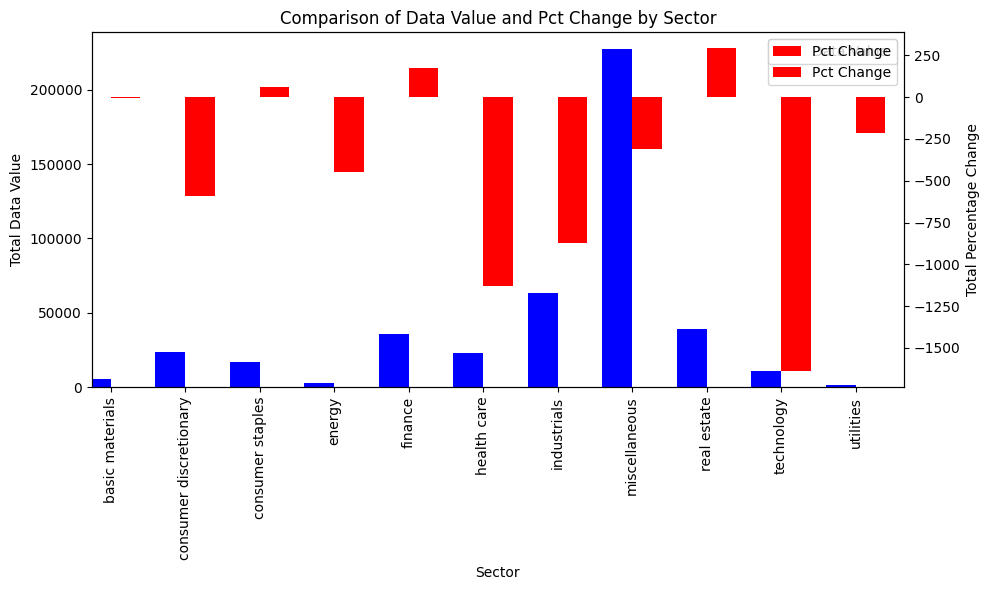

In [58]:
#Visual 1 - FILL IN
# 1. Read the CSV into a pandas DataFrame
df = pd.read_csv('./data_files/combined_bea_nasdaq_data.csv')

# 2. Create a figure and a set of subplots.
fig, ax1 = plt.subplots(figsize=(10, 6))

# 3. Create a second y-axis that shares the same x-axis.
ax2 = ax1.twinx()

# 4. Plot the 'total_datavalue' on ax1 (left y-axis).
#    We use kind='bar', x='sector', y='total_datavalue'.
width = 0.4  # Controls the bar width
df.plot(
    kind='bar',
    x='sector',
    y='total_datavalue',
    color='blue',
    ax=ax1,
    width=width,
    position=1,
    label='Data Value'
)

# 5. Plot the 'total_pctchange' on ax2 (right y-axis).
df.plot(
    kind='bar',
    x='sector',
    y='total_pctchange',
    color='red',
    ax=ax2,
    width=width,
    position=0,
    label='Pct Change'
)

# 6. Label the axes and set a title.
ax1.set_ylabel('Total Data Value')
ax2.set_ylabel('Total Percentage Change')
ax1.set_xlabel('Sector')
ax1.set_title('Comparison of Data Value and Pct Change by Sector')

# 7. Adjust x-axis labels if needed (rotate for readability).
plt.xticks(rotation=45, ha='right')

# 8. Create a combined legend. (Sometimes you need to adjust the position.)
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc='upper right')

# 9. Show the plot.
plt.tight_layout()
plt.show()

*Answer to research question:* FILL IN

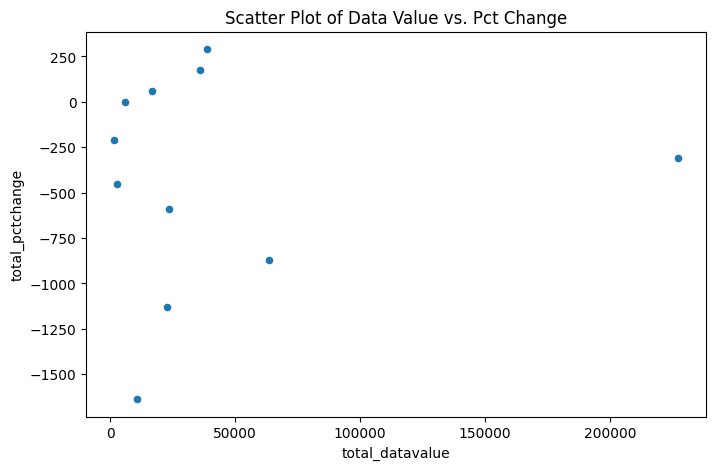

In [59]:
#Visual 2 - FILL IN
# Scatter plot of Data Value vs. Pct Change
df.plot(
    kind='scatter',
    x='total_datavalue',
    y='total_pctchange',
    figsize=(8, 5),
    title='Scatter Plot of Data Value vs. Pct Change'
)
plt.show()

*Answer to research question:* There was not enough data to come to a true correlation between the nasdaq data, and the data from the BEA. If I were to use other sources, especially total stock price data and map the individual stock returns based on industry there might be room for some correlation there. As it stands I believe that the research question was left unanswered.

### **5.2:** Reflection
In 2-4 sentences, if you had more time to complete the project, what actions would you take? For example, which data quality and structural issues would you look into further, and what research questions would you further explore?

*Answer:* If I had more time, I would make heavier use of the Kaggle all stocks dataset. Unfortunately that file was too large and wouldn't allow me to merge it into my git repository. I started by adding a .gitignore file to include it regardless, however then I couldn't upload the project to Udacity either. So I had to start from scratch with a new approach. If I had to do this over, I would be more meticulous in my data sourcing, as well as work to more closely scrutinize what question(s) I hope to answer